# Name: Dristanta Das

## The CIFAR 100 Dataset

This dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs).
Here is the list of classes in the CIFAR-100:

|Superclass	|Classes|
| --- | --- |
|aquatic mammals|	beaver, dolphin, otter, seal, whale|
|fish|	aquarium fish, flatfish, ray, shark, trout|
|flowers|	orchids, poppies, roses, sunflowers, tulips|
|food containers|	bottles, bowls, cans, cups, plates|
|fruit and vegetables|	apples, mushrooms, oranges, pears, sweet peppers|
|household electrical devices|	clock, computer keyboard, lamp, telephone, television|
|household furniture|	bed, chair, couch, table, wardrobe|
|insects|	bee, beetle, butterfly, caterpillar, cockroach|
|large carnivores|	bear, leopard, lion, tiger, wolf|
|large man-made outdoor things|	bridge, castle, house, road, skyscraper|
|large natural outdoor scenes|	cloud, forest, mountain, plain, sea|
|large omnivores and herbivores|	camel, cattle, chimpanzee, elephant, kangaroo|
|medium-sized mammals|	fox, porcupine, possum, raccoon, skunk|
|non-insect invertebrates|	crab, lobster, snail, spider, worm|
|people|	baby, boy, girl, man, woman|
|reptiles|	crocodile, dinosaur, lizard, snake, turtle|
|small mammals|	hamster, mouse, rabbit, shrew, squirrel|
|trees|	maple, oak, palm, pine, willow|
|vehicles 1|	bicycle, bus, motorcycle, pickup truck, train|
|vehicles 2|	lawn-mower, rocket, streetcar, tank, tractor|


In [3]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


## Data Download 

Data is downloaded and the data is split into train-test-valid. 

In [4]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# choose the training and test datasets
train_data = datasets.CIFAR100('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR100('data', train=False,
                             download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)



Files already downloaded and verified
Files already downloaded and verified


In [5]:
classes=train_data.classes

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

### Some Visualisation of data

<ipython-input-7-2181f8df30a5>:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])


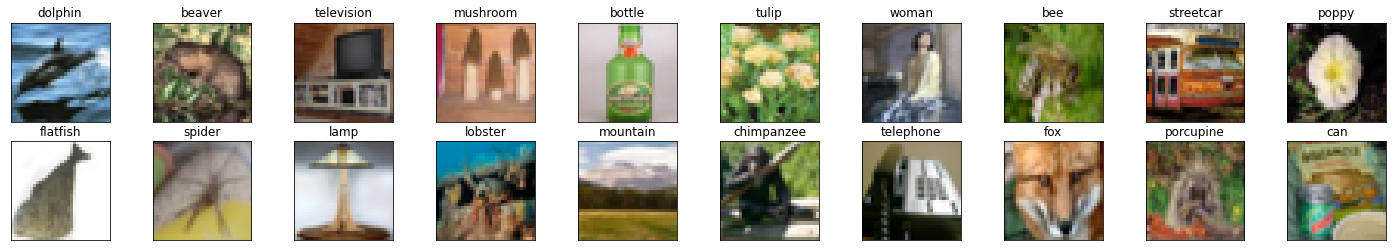

In [7]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

### Defining CIFAR ResNet impementations from https://arxiv.org/abs/1512.03385

In [8]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

from torch.autograd import Variable

def _weights_init(m):
    classname = m.__class__.__name__
    #print(classname)
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=100):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)

        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def resnet20(num_classes=100):
    return ResNet(BasicBlock, [3, 3, 3], num_classes=num_classes)

In [1]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


device cuda:0


In [32]:
learning_rate = 0.1
weight_decay = 1e-4

model = resnet20(num_classes=100)

In [33]:
import torch.optim as optim

In [34]:

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer_sgd = optim.SGD(model.parameters(), lr=0.01)
optimizer_adam = optim.Adam(model.parameters(), lr=0.01)
optimizer_rmsprop = optim.RMSprop(model.parameters(), lr=0.01)

In [35]:
model=model.cuda()

![SGD](SGD.png "SGD")

In [15]:
# number of epochs to train the model
n_epochs = 30

valid_loss_min = np.Inf # track change in validation loss

train_loss_list = []
valid_loss_list = []

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer_sgd.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        #print("conv1 grads",torch.linalg.norm(model.conv1.weight.grad)) 
        #print("conv2 grads",torch.linalg.norm(model.conv2.bias.grad))
        # perform a single optimization step (parameter update)
        optimizer_sgd.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 3.730502 	Validation Loss: 3.536027
Validation loss decreased (inf --> 3.536027).  Saving model ...
Epoch: 2 	Training Loss: 3.475741 	Validation Loss: 3.340418
Validation loss decreased (3.536027 --> 3.340418).  Saving model ...
Epoch: 3 	Training Loss: 3.264459 	Validation Loss: 3.149833
Validation loss decreased (3.340418 --> 3.149833).  Saving model ...
Epoch: 4 	Training Loss: 3.099424 	Validation Loss: 3.000438
Validation loss decreased (3.149833 --> 3.000438).  Saving model ...
Epoch: 5 	Training Loss: 2.949579 	Validation Loss: 2.970573
Validation loss decreased (3.000438 --> 2.970573).  Saving model ...
Epoch: 6 	Training Loss: 2.821437 	Validation Loss: 2.876893
Validation loss decreased (2.970573 --> 2.876893).  Saving model ...
Epoch: 7 	Training Loss: 2.694921 	Validation Loss: 2.717911
Validation loss decreased (2.876893 --> 2.717911).  Saving model ...
Epoch: 8 	Training Loss: 2.589296 	Validation Loss: 2.760667
Epoch: 9 	Training Loss: 2.482899 

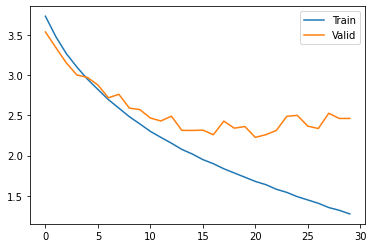

In [18]:
plt.plot(train_loss_list)
plt.plot(valid_loss_list)
plt.legend(["Train","Valid"])

Here we could see that the model when used SGD as optimizer has a tendency of overfit if we could train it for more number of epochs.

## ADAM
![Adam](ADAM.png "Adam")

In [30]:
# number of epochs to train the model
n_epochs = 30

valid_loss_min = np.Inf # track change in validation loss

train_loss_list1 = []
valid_loss_list1 = []

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer_adam.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer_adam.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    train_loss_list1.append(train_loss)
    valid_loss_list1.append(valid_loss)
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar_adam.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 4.062683 	Validation Loss: 3.560229
Validation loss decreased (inf --> 3.560229).  Saving model ...
Epoch: 2 	Training Loss: 3.340821 	Validation Loss: 3.039103
Validation loss decreased (3.560229 --> 3.039103).  Saving model ...
Epoch: 3 	Training Loss: 2.861335 	Validation Loss: 2.653627
Validation loss decreased (3.039103 --> 2.653627).  Saving model ...
Epoch: 4 	Training Loss: 2.535089 	Validation Loss: 2.497058
Validation loss decreased (2.653627 --> 2.497058).  Saving model ...
Epoch: 5 	Training Loss: 2.297021 	Validation Loss: 2.336595
Validation loss decreased (2.497058 --> 2.336595).  Saving model ...
Epoch: 6 	Training Loss: 2.105815 	Validation Loss: 2.256637
Validation loss decreased (2.336595 --> 2.256637).  Saving model ...
Epoch: 7 	Training Loss: 1.947464 	Validation Loss: 2.190325
Validation loss decreased (2.256637 --> 2.190325).  Saving model ...
Epoch: 8 	Training Loss: 1.812029 	Validation Loss: 2.190153
Validation loss decreased (2.19032

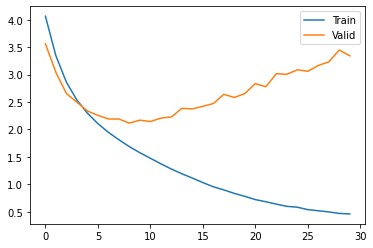

In [31]:
plt.plot(train_loss_list1)
plt.plot(valid_loss_list1)
plt.legend(["Train","Valid"])

![Rmsprop](RMSProp.png "Rmsprop")

In [36]:
# number of epochs to train the model
n_epochs = 30

valid_loss_min = np.Inf # track change in validation loss

train_loss_list2 = []
valid_loss_list2 = []

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer_rmsprop.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer_rmsprop.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    train_loss_list2.append(train_loss)
    valid_loss_list2.append(valid_loss)
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar_rmsprop.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 4.106680 	Validation Loss: 3.507062
Validation loss decreased (inf --> 3.507062).  Saving model ...
Epoch: 2 	Training Loss: 3.266501 	Validation Loss: 3.049953
Validation loss decreased (3.507062 --> 3.049953).  Saving model ...
Epoch: 3 	Training Loss: 2.812668 	Validation Loss: 2.776028
Validation loss decreased (3.049953 --> 2.776028).  Saving model ...
Epoch: 4 	Training Loss: 2.519789 	Validation Loss: 2.471569
Validation loss decreased (2.776028 --> 2.471569).  Saving model ...
Epoch: 5 	Training Loss: 2.294034 	Validation Loss: 2.399516
Validation loss decreased (2.471569 --> 2.399516).  Saving model ...
Epoch: 6 	Training Loss: 2.114641 	Validation Loss: 2.226972
Validation loss decreased (2.399516 --> 2.226972).  Saving model ...
Epoch: 7 	Training Loss: 1.961950 	Validation Loss: 2.170414
Validation loss decreased (2.226972 --> 2.170414).  Saving model ...
Epoch: 8 	Training Loss: 1.835052 	Validation Loss: 2.257077
Epoch: 9 	Training Loss: 1.712741 

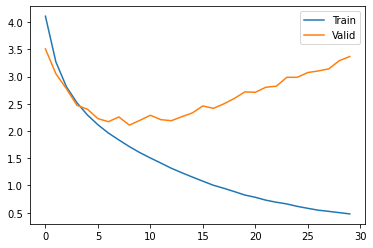

In [37]:
plt.plot(train_loss_list2)
plt.plot(valid_loss_list2)
plt.legend(["Train","Valid"])

Text(0.5, 1.0, 'RMSProp')

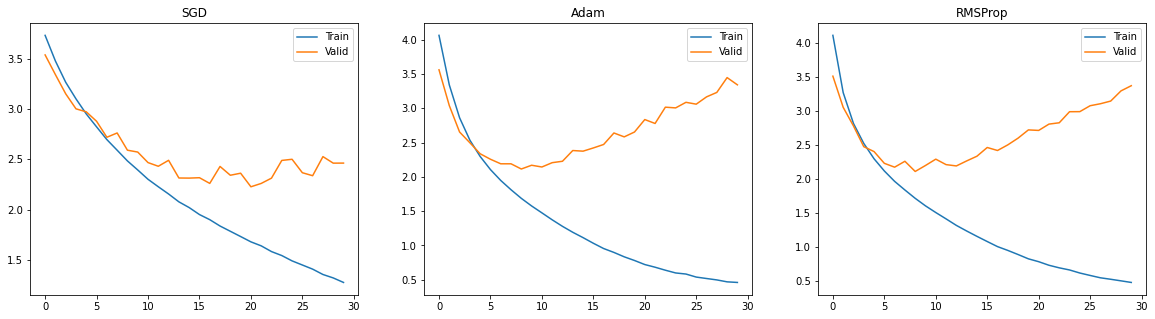

In [38]:
plt.figure(figsize=(20,5))

plt.subplot(131)
plt.plot(train_loss_list)
plt.plot(valid_loss_list)
plt.legend(["Train","Valid"])
plt.title('SGD')
plt.subplot(132)
plt.plot(train_loss_list1)
plt.plot(valid_loss_list1)
plt.legend(["Train","Valid"])
plt.title('Adam')
plt.subplot(133)
plt.plot(train_loss_list2)
plt.plot(valid_loss_list2)
plt.legend(["Train","Valid"])
plt.title('RMSProp')

---
## Testing the Trained Network


## SGD

In [54]:
## SGD

model.load_state_dict(torch.load('model_cifar.pt'))


# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(100))
class_total = list(0. for i in range(100))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(20):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(100):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))


#print(np.sum(class_correct))
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 2.195332

Test Accuracy of apple: 74% (74/100)
Test Accuracy of aquarium_fish: 60% (60/100)
Test Accuracy of  baby: 32% (32/100)
Test Accuracy of  bear: 15% (15/100)
Test Accuracy of beaver: 25% (25/100)
Test Accuracy of   bed: 45% (45/100)
Test Accuracy of   bee: 29% (29/100)
Test Accuracy of beetle: 26% (26/100)
Test Accuracy of bicycle: 46% (46/100)
Test Accuracy of bottle: 46% (46/100)
Test Accuracy of  bowl: 30% (30/100)
Test Accuracy of   boy: 41% (41/100)
Test Accuracy of bridge: 48% (48/100)
Test Accuracy of   bus: 59% (59/100)
Test Accuracy of butterfly: 14% (14/100)
Test Accuracy of camel: 29% (29/100)
Test Accuracy of   can: 57% (57/100)
Test Accuracy of castle: 74% (74/100)
Test Accuracy of caterpillar: 25% (25/100)
Test Accuracy of cattle: 29% (29/100)
Test Accuracy of chair: 56% (56/100)
Test Accuracy of chimpanzee: 75% (75/100)
Test Accuracy of clock: 40% (40/100)
Test Accuracy of cloud: 68% (68/100)
Test Accuracy of cockroach: 55% (55/100)
Test Accuracy of co

### Visualize Sample Test Results

<ipython-input-55-a0724321e9b1>:19: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])


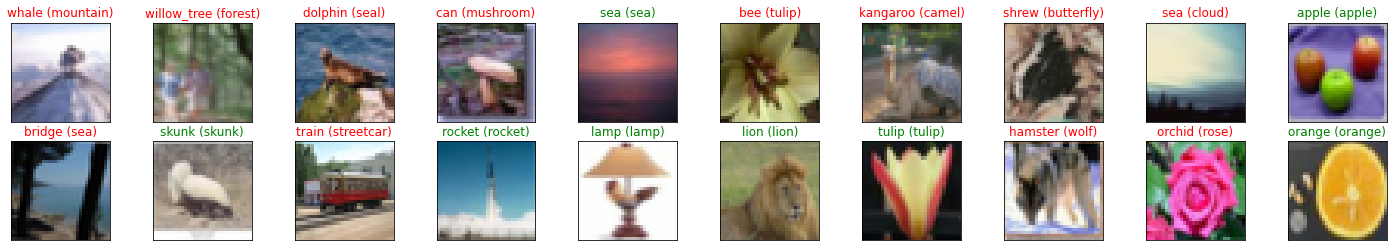

In [55]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx] if not train_on_gpu else images[idx].cpu())
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

## Adam

In [56]:
## Adam

model.load_state_dict(torch.load('model_cifar_adam.pt'))


# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(100))
class_total = list(0. for i in range(100))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(20):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(100):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))


#print(np.sum(class_correct))
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 2.066987

Test Accuracy of apple: 69% (69/100)
Test Accuracy of aquarium_fish: 64% (64/100)
Test Accuracy of  baby: 43% (43/100)
Test Accuracy of  bear: 23% (23/100)
Test Accuracy of beaver: 18% (18/100)
Test Accuracy of   bed: 44% (44/100)
Test Accuracy of   bee: 35% (35/100)
Test Accuracy of beetle: 62% (62/100)
Test Accuracy of bicycle: 59% (59/100)
Test Accuracy of bottle: 63% (63/100)
Test Accuracy of  bowl: 39% (39/100)
Test Accuracy of   boy:  7% ( 7/100)
Test Accuracy of bridge: 61% (61/100)
Test Accuracy of   bus: 40% (40/100)
Test Accuracy of butterfly: 30% (30/100)
Test Accuracy of camel: 31% (31/100)
Test Accuracy of   can: 58% (58/100)
Test Accuracy of castle: 59% (59/100)
Test Accuracy of caterpillar: 36% (36/100)
Test Accuracy of cattle: 31% (31/100)
Test Accuracy of chair: 80% (80/100)
Test Accuracy of chimpanzee: 68% (68/100)
Test Accuracy of clock: 18% (18/100)
Test Accuracy of cloud: 54% (54/100)
Test Accuracy of cockroach: 59% (59/100)
Test Accuracy of co

<ipython-input-57-a0724321e9b1>:19: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])


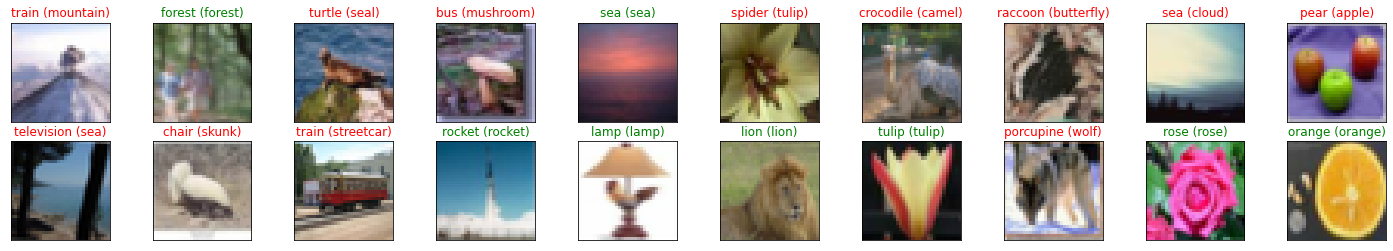

In [57]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx] if not train_on_gpu else images[idx].cpu())
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

In [58]:
## RMSProp

model.load_state_dict(torch.load('model_cifar_rmsprop.pt'))


# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(100))
class_total = list(0. for i in range(100))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(20):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(100):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))


#print(np.sum(class_correct))
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 2.078130

Test Accuracy of apple: 78% (78/100)
Test Accuracy of aquarium_fish: 58% (58/100)
Test Accuracy of  baby: 55% (55/100)
Test Accuracy of  bear:  7% ( 7/100)
Test Accuracy of beaver: 16% (16/100)
Test Accuracy of   bed: 36% (36/100)
Test Accuracy of   bee: 51% (51/100)
Test Accuracy of beetle: 34% (34/100)
Test Accuracy of bicycle: 62% (62/100)
Test Accuracy of bottle: 59% (59/100)
Test Accuracy of  bowl: 32% (32/100)
Test Accuracy of   boy: 15% (15/100)
Test Accuracy of bridge: 56% (56/100)
Test Accuracy of   bus: 25% (25/100)
Test Accuracy of butterfly: 21% (21/100)
Test Accuracy of camel: 37% (37/100)
Test Accuracy of   can: 57% (57/100)
Test Accuracy of castle: 74% (74/100)
Test Accuracy of caterpillar: 42% (42/100)
Test Accuracy of cattle: 42% (42/100)
Test Accuracy of chair: 73% (73/100)
Test Accuracy of chimpanzee: 80% (80/100)
Test Accuracy of clock: 27% (27/100)
Test Accuracy of cloud: 68% (68/100)
Test Accuracy of cockroach: 69% (69/100)
Test Accuracy of co

<ipython-input-59-a0724321e9b1>:19: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])


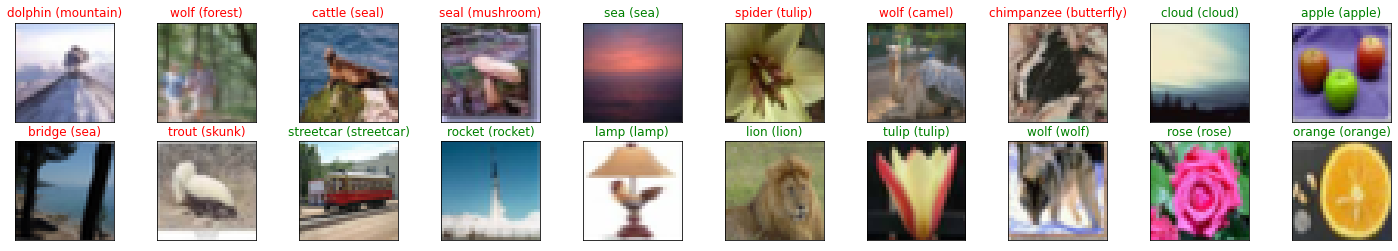

In [59]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx] if not train_on_gpu else images[idx].cpu())
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

## Let's see some custom optimiser

## DemonRanger

In [67]:
from optimizers import *

In [89]:
learning_rate = 0.1
weight_decay = 1e-4

model = resnet20(num_classes=100)
model=model.cuda()

In [90]:
criterion = nn.CrossEntropyLoss()

#### AMSGRAD

![alt3 text](AMSGRAD_def.png "Title3")

## Algorithm
![alt2 text](AMSGRAD.png "Title2")

In [70]:
optimizer_AMSGRAD = DemonRanger(params=model.parameters(),
                        lr=0.01,
                        betas=(0.9,0.999,0.999), # restore default AdamW betas
                        nus=(1.0,1.0), # disables QHMomentum
                        k=0,  # disables lookahead
                        alpha=1.0, 
                        #weight_decay=config.wd,
                        IA=False, # disables Iterate Averaging
                        rectify=False, # disables RAdam Recitification
                        AdaMod=False, #disables AdaMod
                        use_demon=False, #disables Decaying Momentum (DEMON)
                        use_gc=False, #disables gradient centralization
                        amsgrad=True # disables amsgrad
                        )

#### QHAdam


![alt4 text](QHadam_def.png "Title4")


### QHM update rule
QHM, parameterized by α ∈ R, β ∈ R, and ν ∈ R, uses the update rule:
$$ g_{t+1} ← β · g_{t} + (1 − β) · ∇Lˆ_{t}(θ_{t}) $$
$$ θ_{t+1} ← θ_{t} − α[(1 − ν) · ∇Lˆ_{t}(θ_{t}) + ν · g_{t+1}] $$


In [73]:
optimizer_QHAdam = DemonRanger(params=model.parameters(),
                        lr=0.01,
                        k=0,  # disables lookahead
                        alpha=1.0, 
                        IA=False, # disables Iterate Averaging
                        rectify=False, # disables RAdam Recitification
                        AdaMod=False, #disables AdaMod
                        use_demon=False, #disables Decaying Momentum (DEMON)
                        use_gc=False, #disables gradient centralization
                        amsgrad=False # disables amsgrad
                        )

#### Demon Adam

![abc](Demon_Def.png "Title5")



In [91]:
optimizer_Demon = DemonRanger(params=model.parameters(),
                        lr=0.01,
                        #weight_decay=config.wd,
                        #epochs = config.epochs,
                        #step_per_epoch = step_per_epoch, 
                        betas=(0.9,0.999,0.999), # restore default AdamW betas
                        nus=(1.0,1.0), # disables QHMomentum
                        k=0,  # disables lookahead
                        alpha=1.0, 
                        IA=False, # enables Iterate Averaging
                        rectify=False, # disables RAdam Recitification
                        AdaMod=False, #disables AdaMod
                        AdaMod_bias_correct=False, #disables AdaMod bias corretion (not used originally)
                        use_demon=True, #enables Decaying Momentum (DEMON)
                        use_gc=False, #disables gradient centralization
                        amsgrad=False # disables amsgrad
                        )

### Training

In [81]:
## AMSGrad


# number of epochs to train the model
n_epochs = 30

valid_loss_min = np.Inf # track change in validation loss

train_loss_list3 = []
valid_loss_list3 = []

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer_AMSGRAD.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        #print("conv1 grads",torch.linalg.norm(model.conv1.weight.grad)) 
        #print("conv2 grads",torch.linalg.norm(model.conv2.bias.grad))
        # perform a single optimization step (parameter update)
        optimizer_AMSGRAD.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    train_loss_list3.append(train_loss)
    valid_loss_list3.append(valid_loss)
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar_.pt')
        valid_loss_min = valid_loss

/home/sysadm/Documents/Dristanta_ML_Project/optimizers.py:398: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1025.)
  exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)


Epoch: 1 	Training Loss: 4.030989 	Validation Loss: 3.647615
Validation loss decreased (inf --> 3.647615).  Saving model ...
Epoch: 2 	Training Loss: 3.335276 	Validation Loss: 3.061632
Validation loss decreased (3.647615 --> 3.061632).  Saving model ...
Epoch: 3 	Training Loss: 2.894942 	Validation Loss: 2.686971
Validation loss decreased (3.061632 --> 2.686971).  Saving model ...
Epoch: 4 	Training Loss: 2.550194 	Validation Loss: 2.466828
Validation loss decreased (2.686971 --> 2.466828).  Saving model ...
Epoch: 5 	Training Loss: 2.310163 	Validation Loss: 2.326766
Validation loss decreased (2.466828 --> 2.326766).  Saving model ...
Epoch: 6 	Training Loss: 2.120512 	Validation Loss: 2.234374
Validation loss decreased (2.326766 --> 2.234374).  Saving model ...
Epoch: 7 	Training Loss: 1.962311 	Validation Loss: 2.179182
Validation loss decreased (2.234374 --> 2.179182).  Saving model ...
Epoch: 8 	Training Loss: 1.826674 	Validation Loss: 2.207230
Epoch: 9 	Training Loss: 1.704483 

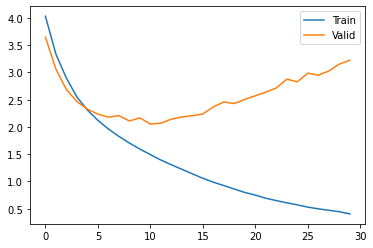

In [82]:
plt.plot(train_loss_list3)
plt.plot(valid_loss_list3)
plt.legend(["Train","Valid"])

In [87]:
## QHAdam


# number of epochs to train the model
n_epochs = 30

valid_loss_min = np.Inf # track change in validation loss

train_loss_list4 = []
valid_loss_list4 = []

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer_QHAdam.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        #print("conv1 grads",torch.linalg.norm(model.conv1.weight.grad)) 
        #print("conv2 grads",torch.linalg.norm(model.conv2.bias.grad))
        # perform a single optimization step (parameter update)
        optimizer_QHAdam.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    train_loss_list4.append(train_loss)
    valid_loss_list4.append(valid_loss)
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar_QHAdam.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 6.031128 	Validation Loss: 6.108565
Validation loss decreased (inf --> 6.108565).  Saving model ...
Epoch: 2 	Training Loss: 6.032455 	Validation Loss: 6.055208
Validation loss decreased (6.108565 --> 6.055208).  Saving model ...
Epoch: 3 	Training Loss: 6.031669 	Validation Loss: 6.061704
Epoch: 4 	Training Loss: 6.030608 	Validation Loss: 6.060126
Epoch: 5 	Training Loss: 6.030455 	Validation Loss: 6.053710
Validation loss decreased (6.055208 --> 6.053710).  Saving model ...
Epoch: 6 	Training Loss: 6.032426 	Validation Loss: 6.138397
Epoch: 7 	Training Loss: 6.033608 	Validation Loss: 6.095640
Epoch: 8 	Training Loss: 6.032398 	Validation Loss: 6.110361
Epoch: 9 	Training Loss: 6.032434 	Validation Loss: 6.079818
Epoch: 10 	Training Loss: 6.031327 	Validation Loss: 6.057736
Epoch: 11 	Training Loss: 6.032192 	Validation Loss: 6.073348
Epoch: 12 	Training Loss: 6.032579 	Validation Loss: 6.075305
Epoch: 13 	Training Loss: 6.030794 	Validation Loss: 6.116459
E

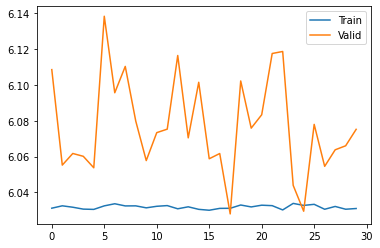

In [88]:
plt.plot(train_loss_list4)
plt.plot(valid_loss_list4)
plt.legend(["Train","Valid"])

In [ ]:
## Demon


# number of epochs to train the model
n_epochs = 30

valid_loss_min = np.Inf # track change in validation loss

train_loss_list5 = []
valid_loss_list5 = []

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer_Demon.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        #print("conv1 grads",torch.linalg.norm(model.conv1.weight.grad)) 
        #print("conv2 grads",torch.linalg.norm(model.conv2.bias.grad))
        # perform a single optimization step (parameter update)
        optimizer_Demon.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    train_loss_list5.append(train_loss)
    valid_loss_list5.append(valid_loss)
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar_Demon.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 4.155434 	Validation Loss: 3.624016
Validation loss decreased (inf --> 3.624016).  Saving model ...
Epoch: 2 	Training Loss: 3.408505 	Validation Loss: 3.101152
Validation loss decreased (3.624016 --> 3.101152).  Saving model ...
Epoch: 3 	Training Loss: 2.943246 	Validation Loss: 2.774654
Validation loss decreased (3.101152 --> 2.774654).  Saving model ...
Epoch: 4 	Training Loss: 2.602039 	Validation Loss: 2.558676
Validation loss decreased (2.774654 --> 2.558676).  Saving model ...
Epoch: 5 	Training Loss: 2.364206 	Validation Loss: 2.401721
Validation loss decreased (2.558676 --> 2.401721).  Saving model ...
Epoch: 6 	Training Loss: 2.174921 	Validation Loss: 2.335534
Validation loss decreased (2.401721 --> 2.335534).  Saving model ...
Epoch: 7 	Training Loss: 2.012397 	Validation Loss: 2.264961
Validation loss decreased (2.335534 --> 2.264961).  Saving model ...
Epoch: 8 	Training Loss: 1.877797 	Validation Loss: 2.165033
Validation loss decreased (2.26496

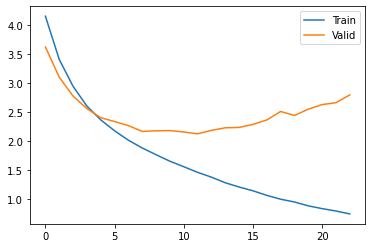

In [4]:
plt.plot(train_loss_list5)
plt.plot(valid_loss_list5)
plt.legend(["Train","Valid"])